## 1. Price only

In [21]:
import pandas as pd
#make sure the sequence of price is correct
price_data = pd.read_csv('../Files/price_emotion_4label_6hour.csv')
price_data.head()

,Unnamed: 0,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,Average_Anger,...,Average_Sadness,Average_Fear,Average_Disgust,Maximum_Anger,Maximum_Joy,Maximum_Sadness,Maximum_Fear,Maximum_Disgust,Percentage,label
0,31835,1.444309e+09,2015-10-08 13:00:00,BTCUSD,0.00,245.00,0.00,245.00,0.606654,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004082,2
1,31834,1.444313e+09,2015-10-08 14:00:00,BTCUSD,245.00,245.00,244.50,245.00,4.453649,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004082,2
2,31833,1.444316e+09,2015-10-08 15:00:00,BTCUSD,245.00,245.00,244.92,244.92,3.016926,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003960,2
3,31832,1.444320e+09,2015-10-08 16:00:00,BTCUSD,244.92,244.92,244.25,244.25,3.895252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001228,2
4,31831,1.444324e+09,2015-10-08 17:00:00,BTCUSD,244.25,244.99,244.02,244.99,3.920632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004245,2


In [22]:
# Real price
price = price_data[['Close']].copy()

In [23]:
price_data = price_data.iloc[:,[1,7,19,20]]
actual_label_list = list(price_data['label'])
print(len(actual_label_list))
print(price_data.tail())

31836
       Unix Timestamp    Close  Percentage  label
31831    1.558900e+12  8600.49         0.0      1
31832    1.558900e+12  8654.41         0.0      1
31833    1.558910e+12  8656.11         0.0      1
31834    1.558910e+12  8750.01         0.0      1
31835    1.558920e+12  8775.00         0.0      1


In [24]:
import numpy as np
def create_dataset(dataset,look_back,future_hours,price_column_index):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = list(dataset[i-look_back : i, price_column_index])
        dataX.append(a)
        if i+6 < len(dataset):
            dataY.append(dataset[i+ future_hours , price_column_index])
        else:
            dataY.append(0)
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [25]:
price_data_np = price_data.as_matrix()
future = 6
back = 51
price_column_index = 1
PX, PY = create_dataset(price_data_np,back,future,price_column_index)
PX = pd.DataFrame(PX)
PY = pd.DataFrame(PY)
#truncate last 6 rows
trun_actual_label_list = actual_label_list[back:-future]
PY = PY[:-future]
PX = PX[:-future]
print(len(trun_actual_label_list))
print(len(PY))

C:\Users\Ray\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


31785
31779
31779


### price only - 60%

In [26]:
# 60% training
from sklearn.linear_model import LinearRegression
model = LinearRegression()
PX_train = PX[0:int(len(PX)*0.6)]
PX_test = PX[int(len(PX)*0.6):len(PX)]
PY_train = PY[0:int(len(PY)*0.6)]
PY_test = PY[int(len(PY)*0.6):len(PY)]
PY_test_label = trun_actual_label_list[int(len(trun_actual_label_list)*0.6):len(trun_actual_label_list)]
model.fit(PX_train,PY_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
# R² score of our model
score = model.score(PX_test,PY_test)
print(score)

0.9942730035260032


In [28]:
PY_pred = model.predict(PX_test) 
PY_pred_train = model.predict(PX_train) 

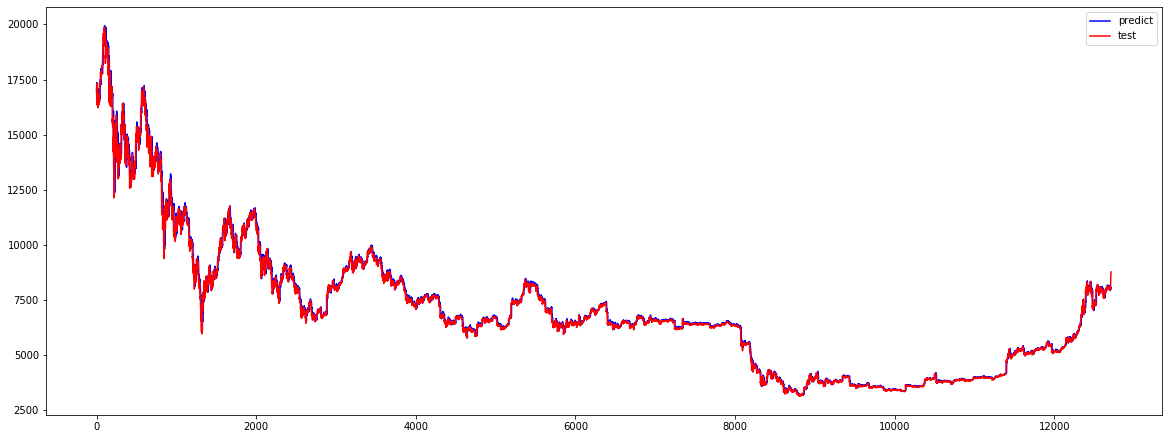

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (20, 7.5))
plt.plot(range(len(PY_pred)),PY_pred,'b',label="predict")
plt.plot(range(len(PY_pred)),PY_test,'r',label="test")
plt.legend(loc="upper right")
# plt.xlim([4000,6000])
plt.show()

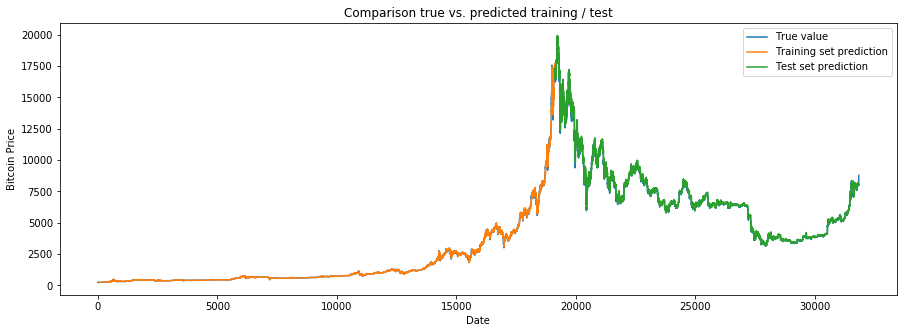

In [30]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[len(price)-len(PX):len(PX_train) + len(price)-len(PX), :] = PY_pred_train

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(price)-len(PY_pred):len(price), :] = PY_pred


plt.figure(figsize = (15, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(17500,17600)
# plt.ylim(7500,17500)
plt.show()

In [31]:
real_price = PY
pred_price = pd.concat([pd.DataFrame(PY_pred_train), pd.DataFrame(PY_pred)], axis=0)
pred_price.index = range(0,len(pred_price))
df60 = pd.concat([real_price, pred_price], axis=1)
df60.columns = ['True','Pred']

In [32]:
row_count_df60 = df60.shape[0]
value_diff_60 = []
for i in range(row_count_df60):
    diff = df60['True'][i]-df60['Pred'][i]
    value_diff_60.append(diff)
df60['Diff'] = value_diff_60
df60.head()

### price only - 70%

In [34]:
# 70% training
from sklearn.linear_model import LinearRegression
model = LinearRegression()
PX_train = PX[0:int(len(PX)*0.7)]
PX_test = PX[int(len(PX)*0.7):len(PX)]
PY_train = PY[0:int(len(PY)*0.7)]
PY_test = PY[int(len(PY)*0.7):len(PY)]
PY_test_label = trun_actual_label_list[int(len(trun_actual_label_list)*0.7):len(trun_actual_label_list)]
model.fit(PX_train,PY_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# R² score of our model
score = model.score(PX_test,PY_test)
print(score)

0.99605016404071


In [36]:
PY_pred = model.predict(PX_test) 
PY_pred_train = model.predict(PX_train) 

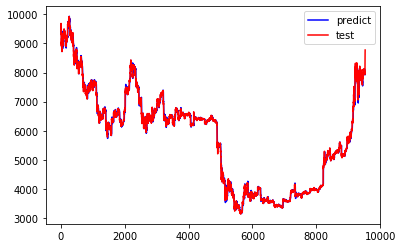

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(len(PY_pred)),PY_pred,'b',label="predict")
plt.plot(range(len(PY_pred)),PY_test,'r',label="test")
plt.legend(loc="upper right")
# plt.xlim([4000,6000])
plt.show()

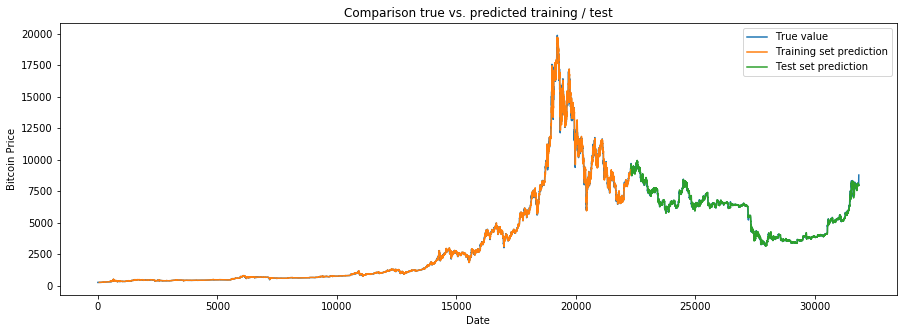

In [38]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[len(price)-len(PX):len(PX_train) + len(price)-len(PX), :] = PY_pred_train

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(price)-len(PY_pred):len(price), :] = PY_pred


plt.figure(figsize = (15, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(17500,17600)
# plt.ylim(7500,17500)
plt.show()

In [39]:
# Create dataframe for true price, predicted price, difference
real_price = PY
pred_price = pd.concat([pd.DataFrame(PY_pred_train), pd.DataFrame(PY_pred)], axis=0)
pred_price.index = range(0,len(pred_price))
df70 = pd.concat([real_price, pred_price], axis=1)
df70.columns = ['True','Pred']

In [40]:
row_count_df70 = df70.shape[0]
value_diff_70 = []
for i in range(row_count_df70):
    diff = df70['True'][i]-df70['Pred'][i]
    value_diff_70.append(diff)
df70['Diff'] = value_diff_70
df70.head()

,True,Pred,Diff
0,245.75,249.487067,-3.737067
1,246.30,249.348607,-3.048607
2,246.30,249.467384,-3.167384
3,246.30,249.768940,-3.468940
4,246.30,249.500409,-3.200409


### price only - 80%

In [41]:
# 80% training
from sklearn.linear_model import LinearRegression
model = LinearRegression()
PX_train = PX[0:int(len(PX)*0.8)]
PX_test = PX[int(len(PX)*0.8):len(PX)]
PY_train = PY[0:int(len(PY)*0.8)]
PY_test = PY[int(len(PY)*0.8):len(PY)]
PY_test_label = trun_actual_label_list[int(len(trun_actual_label_list)*0.8):len(trun_actual_label_list)]
model.fit(PX_train,PY_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
# R² score of our model
score = model.score(PX_test,PY_test)
print(score)

0.9952545836819339


In [43]:
PY_pred = model.predict(PX_test) 
PY_pred_train = model.predict(PX_train) 

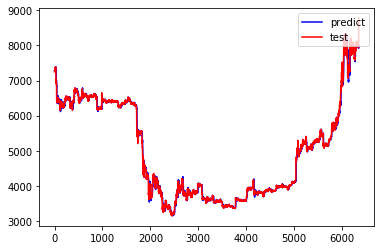

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(len(PY_pred)),PY_pred,'b',label="predict")
plt.plot(range(len(PY_pred)),PY_test,'r',label="test")
plt.legend(loc="upper right")
# plt.xlim([4000,6000])
plt.show()

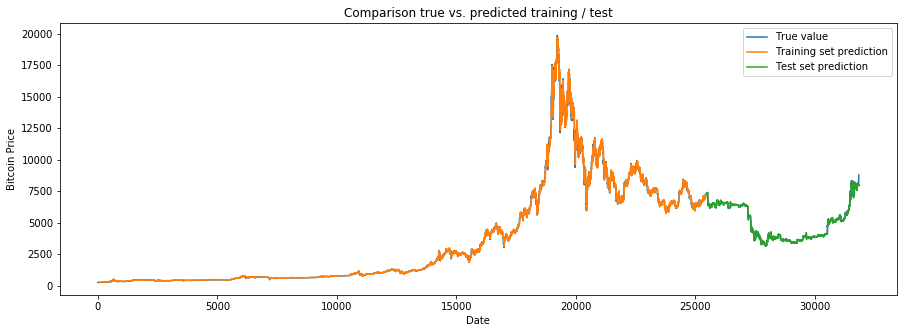

In [45]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[len(price)-len(PX):len(PX_train) + len(price)-len(PX), :] = PY_pred_train

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(price)-len(PY_pred):len(price), :] = PY_pred


plt.figure(figsize = (15, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(17500,17600)
# plt.ylim(7500,17500)
plt.show()

In [46]:
# Create dataframe for true price, predicted price, difference
real_price = PY
pred_price = pd.concat([pd.DataFrame(PY_pred_train), pd.DataFrame(PY_pred)], axis=0)
pred_price.index = range(0,len(pred_price))
df80 = pd.concat([real_price, pred_price], axis=1)
df80.columns = ['True','Pred']

In [47]:
row_count_df80 = df80.shape[0]
value_diff_80 = []
for i in range(row_count_df80):
    diff = df80['True'][i]-df80['Pred'][i]
    value_diff_80.append(diff)
df80['Diff'] = value_diff_80
df80.head()

,True,Pred,Diff
0,245.75,249.664259,-3.914259
1,246.30,249.547582,-3.247582
2,246.30,249.667128,-3.367128
3,246.30,249.959674,-3.659674
4,246.30,249.686662,-3.386662


## 2. Price + sentiment

In [49]:
# use price_sentiment_zero_label_6h.ipnb to process price_sentiment matrix
# delete records with emoty sentiment from head and tail
ps_data = pd.read_csv('../Files/price_sentiment_zero_label.csv')
price = ps_data[['Close']].copy()

In [50]:
ps_data = ps_data.iloc[:,[1,7,9,10,11,12,13,19,20]]
actual_label_list = list(ps_data['label'])
print(len(actual_label_list))
print(ps_data.tail())

29125
       Unix Timestamp    Close  Average_Anger  Average_Joy  Average_Sadness  \
29120    1.553800e+12  4010.55       0.000000     0.000000         0.000000   
29121    1.553810e+12  4013.65       0.000000     0.000000         0.000000   
29122    1.553810e+12  4010.34       0.014506     0.018140         0.011038   
29123    1.553810e+12  4012.81       0.015007     0.017887         0.010961   
29124    1.553820e+12  4014.55       0.015467     0.017642         0.011146   

       Average_Fear  Average_Disgust  Percentage  label  
29120      0.000000         0.000000    0.003453      1  
29121      0.000000         0.000000    0.002342      1  
29122      0.013013         0.012254    0.002035      1  
29123      0.013317         0.012807   -0.000147      2  
29124      0.013458         0.013149   -0.000010      2  


In [51]:
import numpy as np
def create_dataset_ps(dataset,look_back,future_hours,price_column_index):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = list(dataset[i-look_back : i, price_column_index])
        a.extend(list(dataset[i-look_back : i, 3]))
        a.extend(list(dataset[i-look_back : i, 4]))
        a.extend(list(dataset[i-look_back : i, 5]))
        a.extend(list(dataset[i-look_back : i, 6]))
        a.extend(list(dataset[i-look_back : i, 7]))
        dataX.append(a)
        if i+6 < len(dataset):
            dataY.append(dataset[i+ future_hours , price_column_index])
        else:
            dataY.append(0)
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [52]:
ps_data_np = ps_data.as_matrix()
future = 6
back = 51
price_column_index = 1
PX, PY = create_dataset_ps(ps_data_np,back,future,price_column_index)

C:\Users\Ray\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


29074


In [53]:
PX = pd.DataFrame(PX)
PY = pd.DataFrame(PY)
#truncate last 6 rows
trun_actual_label_list = actual_label_list[back:-future]
PY = PY[:-future]
PX = PX[:-future]
print(len(trun_actual_label_list))
print(len(PY))

29068
29068


### Price-sentiment 60%

In [54]:
# 60% training
from sklearn.linear_model import LinearRegression
model = LinearRegression()
PX_train = PX[0:int(len(PX)*0.6)]
PX_test = PX[int(len(PX)*0.6):len(PX)]
PY_train = PY[0:int(len(PY)*0.6)]
PY_test = PY[int(len(PY)*0.6):len(PY)]
PY_test_label = trun_actual_label_list[int(len(trun_actual_label_list)*0.6):len(trun_actual_label_list)]
model.fit(PX_train,PY_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
# R² score of our model
score = model.score(PX_test,PY_test)
print(score)

0.9959114150126758


In [56]:
PY_pred = model.predict(PX_test) 
PY_pred_train = model.predict(PX_train) 

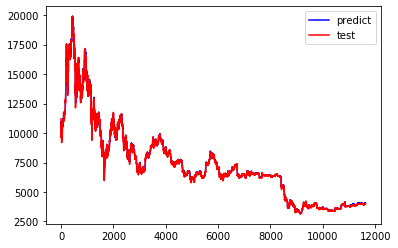

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(len(PY_pred)),PY_pred,'b',label="predict")
plt.plot(range(len(PY_pred)),PY_test,'r',label="test")
plt.legend(loc="upper right")
# plt.xlim([4000,6000])
plt.show()

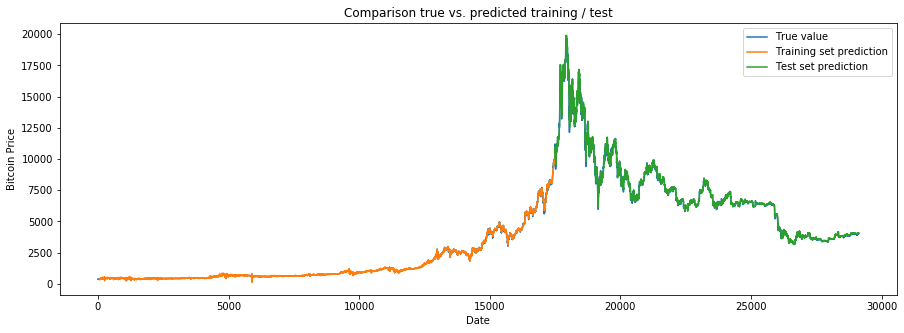

In [58]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[len(price)-len(PX):len(PX_train) + len(price)-len(PX), :] = PY_pred_train

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(price)-len(PY_pred):len(price), :] = PY_pred


plt.figure(figsize = (15, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(17500,17600)
# plt.ylim(7500,17500)
plt.show()

In [59]:
# Create dataframe for true price, predicted price, difference
real_price = PY
pred_price = pd.concat([pd.DataFrame(PY_pred_train), pd.DataFrame(PY_pred)], axis=0)
pred_price.index = range(0,len(pred_price))
df60 = pd.concat([real_price, pred_price], axis=1)
df60.columns = ['True','Pred']

In [60]:
row_count_df60 = df60.shape[0]
value_diff_60 = []
for i in range(row_count_df60):
    diff = df60['True'][i]-df60['Pred'][i]
    value_diff_60.append(diff)
df60['Diff'] = value_diff_60
df60.head()

,True,Pred,Diff
0,361.06,377.201616,-16.141616
1,362.60,368.618644,-6.018644
2,363.00,375.707183,-12.707183
3,362.50,362.708652,-0.208652
4,356.63,354.940551,1.689449


### Price-sentiment 70%

In [61]:
# 70% training
from sklearn.linear_model import LinearRegression
model = LinearRegression()
PX_train = PX[0:int(len(PX)*0.7)]
PX_test = PX[int(len(PX)*0.7):len(PX)]
PY_train = PY[0:int(len(PY)*0.7)]
PY_test = PY[int(len(PY)*0.7):len(PY)]
PY_test_label = trun_actual_label_list[int(len(trun_actual_label_list)*0.7):len(trun_actual_label_list)]
model.fit(PX_train,PY_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
PY_pred = model.predict(PX_test) 
PY_pred_train = model.predict(PX_train) 

# R² score of our model
score = model.score(PX_test,PY_test)
print(score)

0.9989837102647534


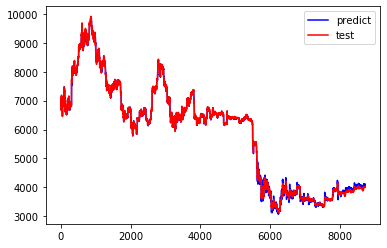

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(len(PY_pred)),PY_pred,'b',label="predict")
plt.plot(range(len(PY_pred)),PY_test,'r',label="test")
plt.legend(loc="upper right")
# plt.xlim([4000,6000])
plt.show()

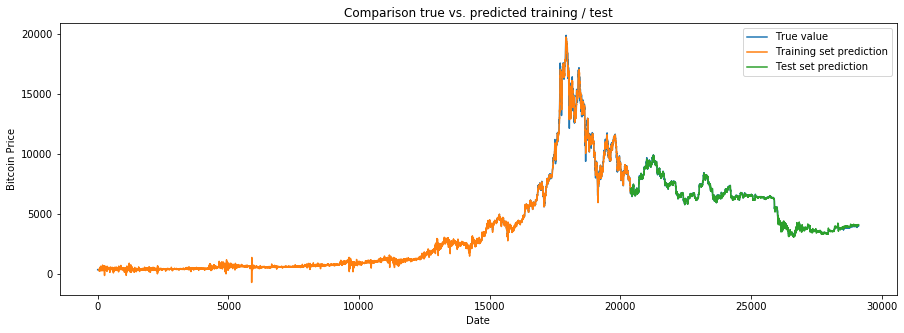

In [64]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[len(price)-len(PX):len(PX_train) + len(price)-len(PX), :] = PY_pred_train

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(price)-len(PY_pred):len(price), :] = PY_pred


plt.figure(figsize = (15, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(17500,17600)
# plt.ylim(7500,17500)
plt.show()

In [65]:
# Create dataframe for true price, predicted price, difference
real_price = PY
pred_price = pd.concat([pd.DataFrame(PY_pred_train), pd.DataFrame(PY_pred)], axis=0)
pred_price.index = range(0,len(pred_price))
df70 = pd.concat([real_price, pred_price], axis=1)
df70.columns = ['True','Pred']

In [66]:
row_count_df70 = df70.shape[0]
value_diff_70 = []
for i in range(row_count_df70):
    diff = df70['True'][i]-df70['Pred'][i]
    value_diff_70.append(diff)
df70['Diff'] = value_diff_70
df70.head()

,True,Pred,Diff
0,361.06,407.033315,-45.973315
1,362.60,405.890080,-43.290080
2,363.00,412.171206,-49.171206
3,362.50,365.273435,-2.773435
4,356.63,353.495493,3.134507


### Price-sentiment 80%

In [67]:
# 80% training
from sklearn.linear_model import LinearRegression
model = LinearRegression()
PX_train = PX[0:int(len(PX)*0.8)]
PX_test = PX[int(len(PX)*0.8):len(PX)]
PY_train = PY[0:int(len(PY)*0.8)]
PY_test = PY[int(len(PY)*0.8):len(PY)]
PY_test_label = trun_actual_label_list[int(len(trun_actual_label_list)*0.8):len(trun_actual_label_list)]
model.fit(PX_train,PY_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
PY_pred = model.predict(PX_test) 
PY_pred_train = model.predict(PX_train) 

# R² score of our model
score = model.score(PX_test,PY_test)
print(score)

0.9988389276165485


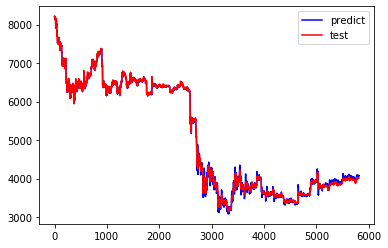

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(len(PY_pred)),PY_pred,'b',label="predict")
plt.plot(range(len(PY_pred)),PY_test,'r',label="test")
plt.legend(loc="upper right")
# plt.xlim([4000,6000])
plt.show()

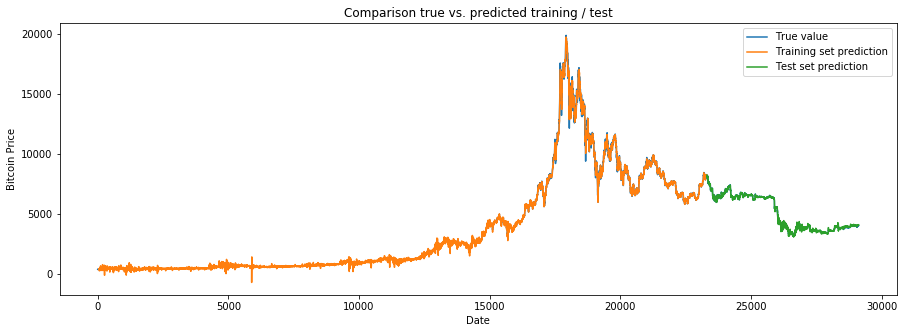

In [70]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[len(price)-len(PX):len(PX_train) + len(price)-len(PX), :] = PY_pred_train

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(price)-len(PY_pred):len(price), :] = PY_pred


plt.figure(figsize = (15, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(17500,17600)
# plt.ylim(7500,17500)
plt.show()

In [71]:
# Create dataframe for true price, predicted price, difference
real_price = PY
pred_price = pd.concat([pd.DataFrame(PY_pred_train), pd.DataFrame(PY_pred)], axis=0)
pred_price.index = range(0,len(pred_price))
df80 = pd.concat([real_price, pred_price], axis=1)
df80.columns = ['True','Pred']

In [72]:
row_count_df80 = df80.shape[0]
value_diff_80 = []
for i in range(row_count_df80):
    diff = df80['True'][i]-df80['Pred'][i]
    value_diff_80.append(diff)
df80['Diff'] = value_diff_80
df80.head()

,True,Pred,Diff
0,361.06,412.587528,-51.527528
1,362.60,410.991168,-48.391168
2,363.00,418.081362,-55.081362
3,362.50,370.915799,-8.415799
4,356.63,358.930045,-2.300045


In [73]:
PX

,0,1,2,3,4,5,6,7,8,9,...,296,297,298,299,300,301,302,303,304,305
0,364.34,361.85,362.00,364.56,360.87,359.01,364.00,363.05,361.76,363.00,...,-0.024760,-0.006632,-0.007671,0.002992,-0.012380,0.004799,0.011111,0.008310,0.002292,0.005028
1,361.85,362.00,364.56,360.87,359.01,364.00,363.05,361.76,363.00,364.00,...,-0.006632,-0.007671,0.002992,-0.012380,0.004799,0.011111,0.008310,0.002292,0.005028,0.005738
2,362.00,364.56,360.87,359.01,364.00,363.05,361.76,363.00,364.00,363.90,...,-0.007671,0.002992,-0.012380,0.004799,0.011111,0.008310,0.002292,0.005028,0.005738,0.006943
3,364.56,360.87,359.01,364.00,363.05,361.76,363.00,364.00,363.90,352.00,...,0.002992,-0.012380,0.004799,0.011111,0.008310,0.002292,0.005028,0.005738,0.006943,-0.002747
4,360.87,359.01,364.00,363.05,361.76,363.00,364.00,363.90,352.00,349.00,...,-0.012380,0.004799,0.011111,0.008310,0.002292,0.005028,0.005738,0.006943,-0.002747,-0.004121
5,359.01,364.00,363.05,361.76,363.00,364.00,363.90,352.00,349.00,352.45,...,0.004799,0.011111,0.008310,0.002292,0.005028,0.005738,0.006943,-0.002747,-0.004121,-0.017602
6,364.00,363.05,361.76,363.00,364.00,363.90,352.00,349.00,352.45,352.52,...,0.011111,0.008310,0.002292,0.005028,0.005738,0.006943,-0.002747,-0.004121,-0.017602,-0.021494
7,363.05,361.76,363.00,364.00,363.90,352.00,349.00,352.45,352.52,352.19,...,0.008310,0.002292,0.005028,0.005738,0.006943,-0.002747,-0.004121,-0.017602,-0.021494,-0.007090
8,361.76,363.00,364.00,363.90,352.00,349.00,352.45,352.52,352.19,353.81,...,0.002292,0.005028,0.005738,0.006943,-0.002747,-0.004121,-0.017602,-0.021494,-0.007090,-0.007170
9,363.00,364.00,363.90,352.00,349.00,352.45,352.52,352.19,353.81,353.81,...,0.005028,0.005738,0.006943,-0.002747,-0.004121,-0.017602,-0.021494,-0.007090,-0.007170,-0.008264
